In [1]:
from zipline import run_algorithm
import matplotlib.pyplot as plt
import math
from zipline.api import (order_target_percent,symbol,set_commission,set_benchmark,order,record)
import numpy as np
from zipline.finance.commission import PerTrade
import pandas as pd
from zipline.api import order_target, record, symbol, set_commission, set_slippage, set_long_only,order_target_percent, order, schedule_function,  date_rules,time_rules
from zipline.finance import commission
import warnings
import matplotlib.pyplot as plt
from zipline.utils.calendar_utils import get_calendar
# import talib
# from talib import MACD # type: ignore
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
from zipline.utils.run_algo import load_extensions
#from utils.utils import *
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, INFO, WARNING, DEBUG, ERROR)
import pytz
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
import yfinance as yf

/home/popeye/.local/lib/python3.10/site-packages/quantstats/utils.py:300: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic("matplotlib inline")


In [2]:
calendar_name = 'XNYS'
calendar = get_calendar(calendar_name)

## Using ADfuller for determining Stationary or non-Stationary

[*********************100%%**********************]  1 of 1 completed

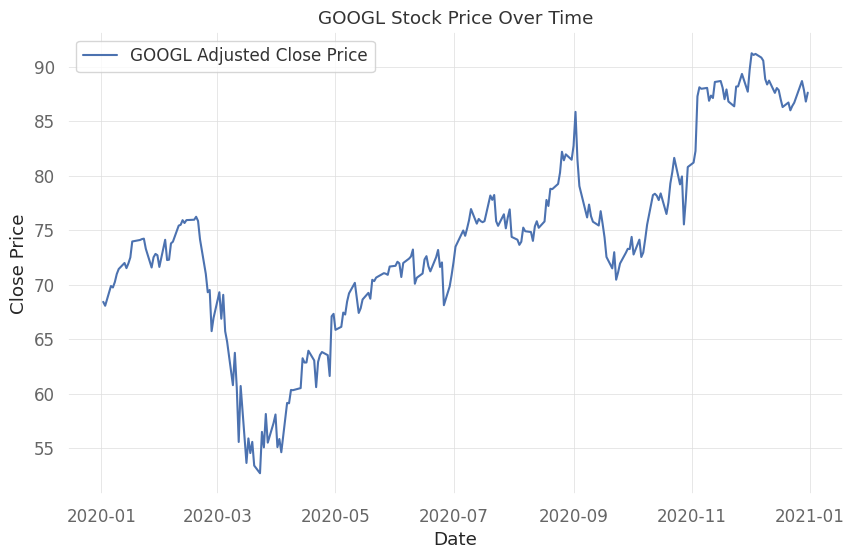

ADF Statistic: -1.2425160721887476
P-Value: 0.655044345046655
Critical Values: {'1%': -3.4575505077947746, '5%': -2.8735087323013526, '10%': -2.573148434859185}


In [89]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

symbol = "GOOGL"
stock_data = yf.download(symbol, start="2020-01-01", end="2021-01-01")

price_data = stock_data['Close']

plt.figure(figsize=(10, 6))
plt.plot(price_data, label='GOOGL Adjusted Close Price')
plt.title('GOOGL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

result = adfuller(price_data, autolag='AIC')

print('ADF Statistic:', result[0])
print('P-Value:', result[1])
print('Critical Values:', result[4])


The **p-value** is significantly greater than 0.05, so you would likely fail to reject the null hypothesis. This suggests that the GOOGL stock prices, based on the ADF test, may exhibit **non-stationary** behavior.



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## Implementing Keltner

In [98]:
from zipline.api import order_target_percent, symbol, record
import pandas as pd

def calculate_keltner_channels(prices, window_size=20, atr_multiplier=2):
    typical_price = (prices['high'] + prices['low'] + prices['close']) / 3
    atr = typical_price.diff().abs().rolling(window=window_size).mean()
    upper_channel = typical_price + atr_multiplier * atr
    lower_channel = typical_price - atr_multiplier * atr

    return upper_channel, lower_channel

def keltner_strategy(prices, window_size=20, atr_multiplier=2):
    upper_channel, lower_channel = calculate_keltner_channels(prices, window_size, atr_multiplier)
    current_price = prices['close'].iloc[-1]

    if current_price > upper_channel.iloc[-1]:
        return -1  # Sell signal
    elif current_price < lower_channel.iloc[-1]:
        return 1   # Buy signal
    else:
        return 0   # No signal

def initialize(context):
    context.asset = symbol('GOOGL')
    context.set_commission(commission.PerShare(cost=0.0075, min_trade_cost=1.0))

def handle_data(context, data):
    prices = data.history(context.asset, ['high', 'low', 'close'], bar_count=50, frequency='1d')
    
    # Remove duplicate timestamps
    prices = prices[~prices.index.duplicated(keep='first')]

    signal = keltner_strategy(prices)

    if signal == 1:
        order_target_percent(context.asset, 1)   # Buy signal
    elif signal == -1:
        order_target_percent(context.asset, -1)  # Sell signal

    record(
        upper_channel=prices['high'].iloc[-1],
        lower_channel=prices['low'].iloc[-1],
        current_price=prices['close'].iloc[-1],
        signal=signal
    )

start_date = pd.to_datetime('2020-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=10000,
    trading_calendar=calendar,
    bundle='spStocks',
    data_frequency='daily',
)

/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/popeye/.local/lib/python3.10/site-package

In [99]:
results.index = pd.to_datetime(results.index).tz_convert(None)

start = results.index[0]
end = results.index[-1]
benchmark = yf.download("AAPL", start=start, end=end)["Close"].pct_change()
qs.reports.full(results.returns, benchmark=benchmark)

[*********************100%%**********************]  1 of 1 completed


/home/popeye/.local/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/popeye/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/popeye/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


ValueError: Cannot calculate a linear regression if all x values are identical

In [74]:
from zipline.api import order, symbol
import pandas as pd

def calculate_keltner_channels(prices, window_size=20, atr_multiplier=2):
    typical_price = (prices['high'] + prices['low'] + prices['close']) / 3
    atr = typical_price.diff().abs().rolling(window=window_size).mean()
    upper_channel = typical_price + atr_multiplier * atr
    lower_channel = typical_price - atr_multiplier * atr

    return upper_channel, lower_channel

def initialize(context):
    context.asset = symbol('GOOGL')
    context.set_commission(commission.PerShare(cost=0.0075, min_trade_cost=1.0))
    context.stop_loss_pct = 0.03  # 3% stop loss

def handle_data(context, data):
    prices = data.history(context.asset, ['high', 'low', 'close'], bar_count=50, frequency='1d')
    upper_channel, lower_channel = calculate_keltner_channels(prices)

    current_price = data.current(context.asset, 'close')

    # Filter: Only take signals when the current price is above the 50-day moving average
    if current_price < data.history(context.asset, 'close', bar_count=50, frequency='1d').mean():
        return

    # Stop Loss: Sell if the current price is below the stop-loss level
    if context.portfolio.positions[context.asset].cost_basis * (1 - context.stop_loss_pct) > current_price:
        order(context.asset, -context.portfolio.positions[context.asset].amount)  # Sell to exit the position
        return

    if current_price > upper_channel.iloc[-1]:
        order(context.asset, -1)  # Sell signal
    elif current_price < lower_channel.iloc[-1]:
        order(context.asset, 1)   # Buy signal

    record(
        upper_channel=upper_channel.iloc[-1],
        lower_channel=lower_channel.iloc[-1],
        current_price=current_price
    )
start_date = pd.to_datetime('2020-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=10000,
    trading_calendar=calendar,
    bundle='spStocks',
    data_frequency='daily',
)

/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/popeye/.local/lib/python3.10/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/popeye/.local/lib/python3.10/site-package

In [75]:
results.index = pd.to_datetime(results.index).tz_convert(None)

start = results.index[0]
end = results.index[-1]
benchmark = yf.download("GOOGL", start=start, end=end)["Close"].pct_change()
benchmark

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-03         NaN
2020-01-06    0.026654
2020-01-07   -0.001932
2020-01-08    0.007118
2020-01-09    0.010498
                ...   
2020-12-24    0.003431
2020-12-28    0.022951
2020-12-29   -0.009132
2020-12-30   -0.012237
2020-12-31    0.009440
Name: Close, Length: 252, dtype: float64

/home/popeye/.local/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:933: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:936: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, aggregate="M", prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86:

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-07   2020-01-07
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             33.0%        29.0%

Cumulative Return          25.63%       0.05%
CAGR﹪                     17.37%       0.03%

Sharpe                     0.75         0.26
Prob. Sharpe Ratio         84.45%       60.4%
Smart Sharpe               0.48         0.17
Sortino                    2.29         0.41
Smart Sortino              1.47         0.26
Sortino/√2                 1.62         0.29
Smart Sortino/√2           1.04         0.19
Omega                      1.09         1.09

Max Drawdown               -20.27%      -0.11%
Longest DD Days            254          283
Volatility (ann.)          39.28%       0.18%
R^2                        0.0          0.0
Information Ratio          -0.05        -0.05
Calmar                   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-24,2020-04-20,2020-12-31,283,-0.113633,-0.112250
2,2020-01-08,2020-02-19,2020-02-24,48,-0.064877,-0.062166
3,2020-03-13,2020-03-13,2020-03-13,1,-0.051303,NaN
4,2020-02-28,2020-03-02,2020-03-04,6,-0.035679,-0.033320
5,2020-03-10,2020-03-10,2020-03-10,1,-0.029656,NaN


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


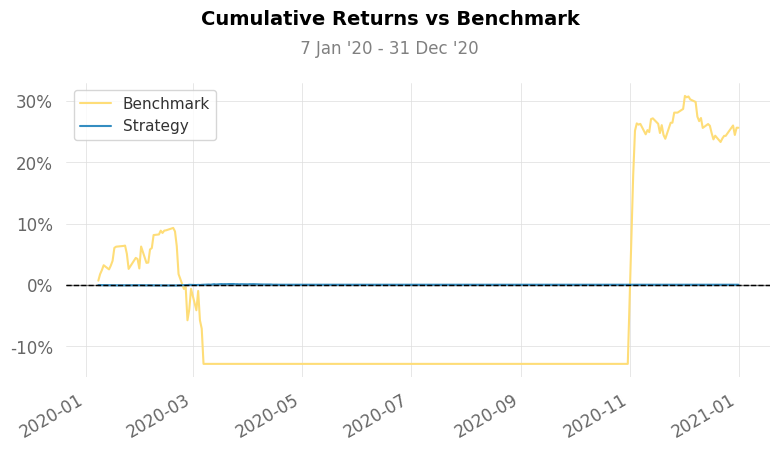

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


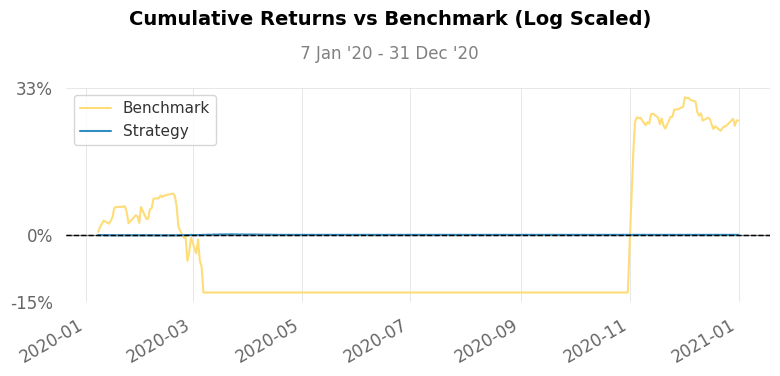

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


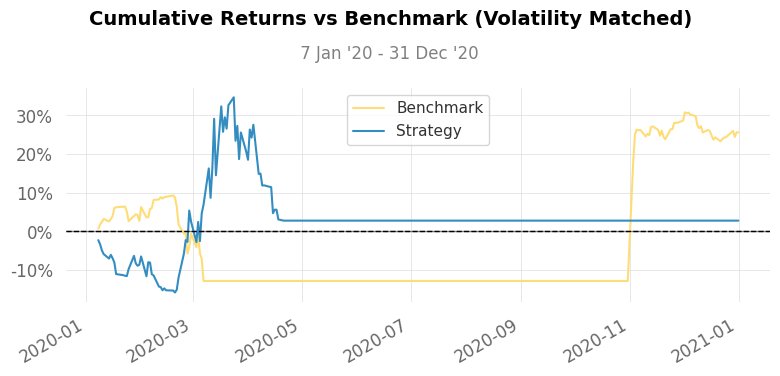

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


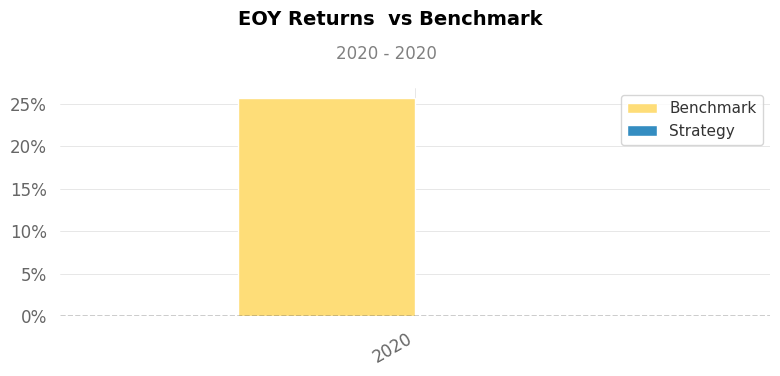

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


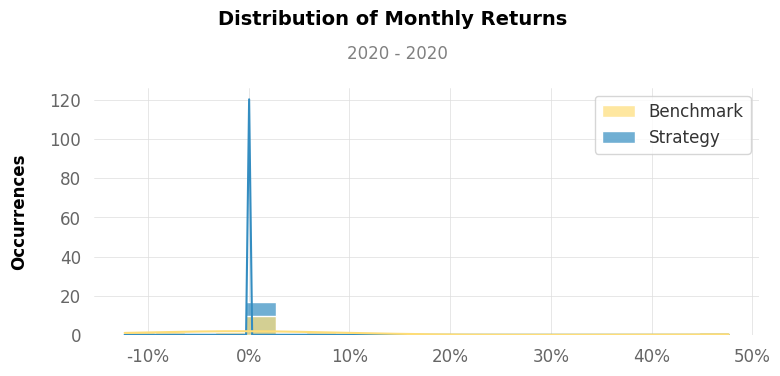

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


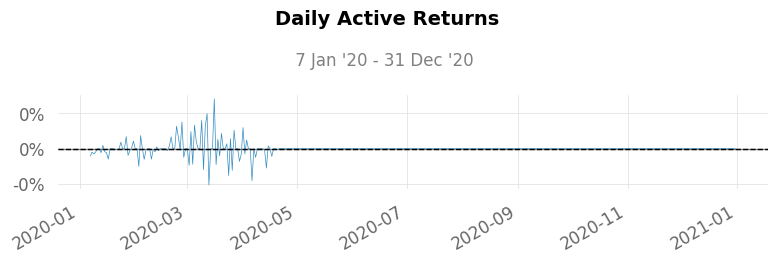

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


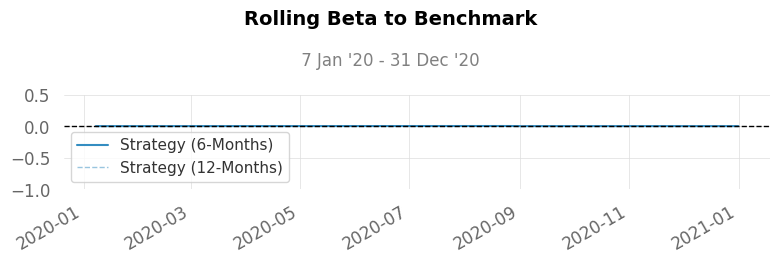

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


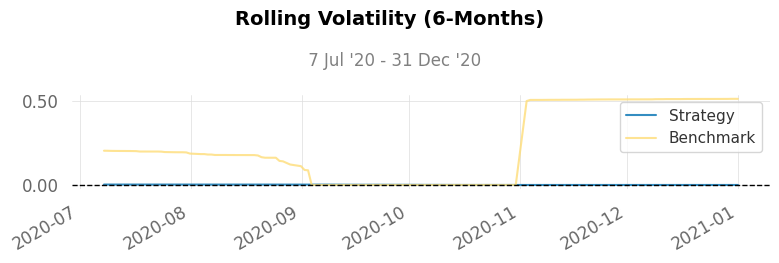

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


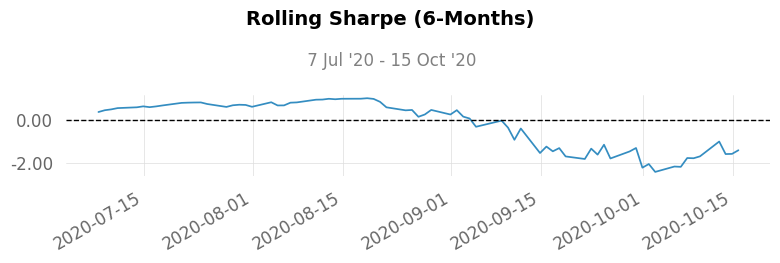

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


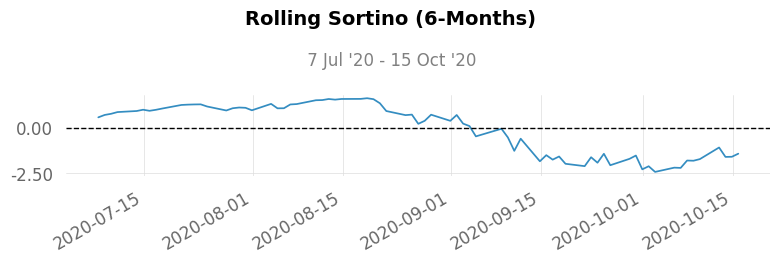

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


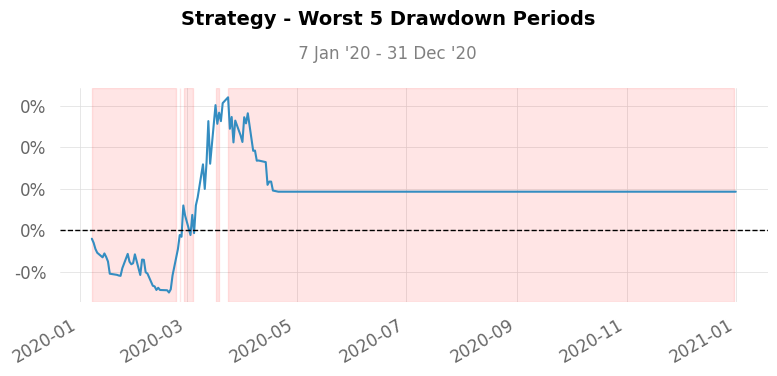

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


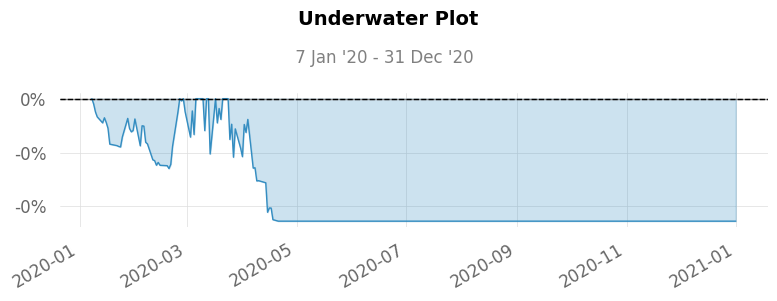

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


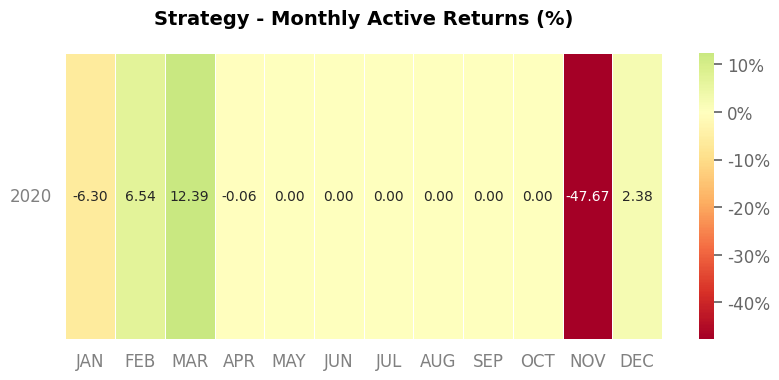

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


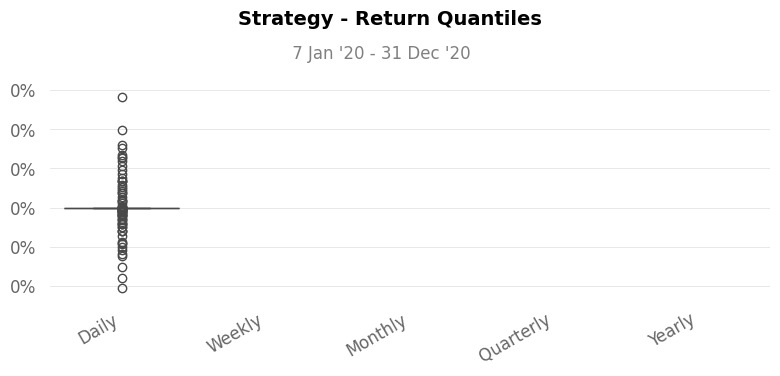

In [76]:
qs.reports.full(results.returns,benchmark=benchmark) 

[*********************100%%**********************]  1 of 1 completed


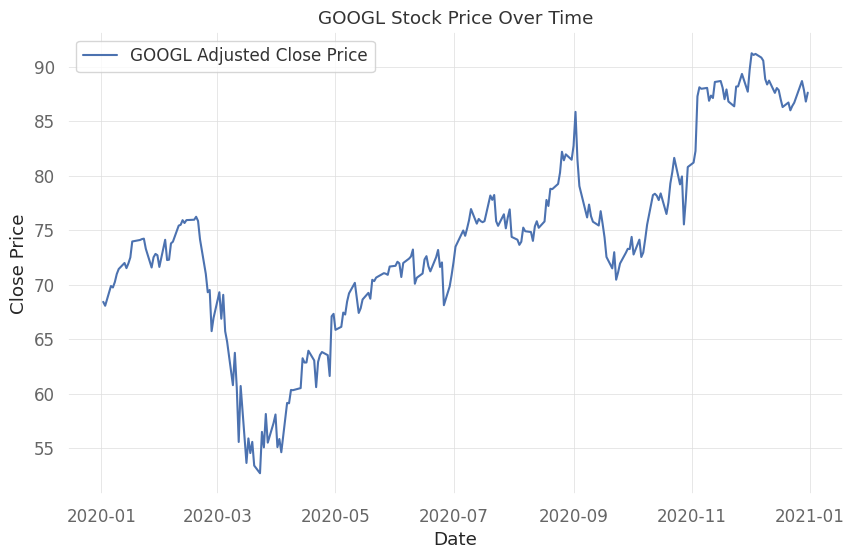

In [45]:
symbol = "GOOGL"
stock_data = yf.download(symbol, start="2020-01-01", end="2021-01-01")

price_data = stock_data['Close']

plt.figure(figsize=(10, 6))
plt.plot(price_data, label='GOOGL Adjusted Close Price')
plt.title('GOOGL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## Implementing ROC(Rate of Change)--> Momentum oscillator.

$$ ROC = (\frac{closing \ Price \ Today - closing \ price \ n \ periods \ ago}{closing \ price \ n \ periods \ ago}) * 100

In [24]:
from zipline.api import order_target_percent, record, symbol
import pandas as pd

def initialize(context):
    context.asset = symbol('GOOGL')
    context.lookback_period = 30  
    context.momentum_threshold = 0

def handle_data(context, data):
    prices = data.history(context.asset, 'price', bar_count=context.lookback_period, frequency='1d')

    if len(prices) < context.lookback_period:
        return

    # Calculate the rate of change (ROC)
    roc = (prices[-1] - prices[0]) / prices[0]

    # Make trading decisions based on ROC
    if roc > context.momentum_threshold:
        order_target_percent(context.asset, 0.5)  # Buy signal
    elif roc < -context.momentum_threshold:
        order_target_percent(context.asset, 0.0)  # Sell signal

    # Record data for analysis
    record(price=data.current(context.asset, 'price'), roc=roc)

# Define the start and end dates for the backtest
start_date = pd.to_datetime('2020-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000', format='%Y-%m-%d %H:%M:%S.%f')
# Run the backtest
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=10000,
    trading_calendar=calendar,
    bundle='spStocks',
    data_frequency='daily',
)



/home/popeye/.local/lib/python3.10/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_7921/2000667515.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roc = (prices[-1] - prices[0]) / prices[0]
/tmp/ipykernel_7921/2000667515.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roc = (prices[-1] - prices[0]) / prices[0]
/tmp/ipykernel_7921/2000667515.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecat

[*********************100%%**********************]  1 of 1 completed

/home/popeye/.local/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:933: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/popeye/.local/lib/python3.10/site-packages/quantstats/reports.py:936: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  _stats.expected_return(df, compounded=compounded, aggregate="M", prepare_returns=False) * pct
/home/popeye/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86:

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             33.0%        75.0%

Cumulative Return          28.73%       14.93%
CAGR﹪                     19.16%       10.14%

Sharpe                     0.81         1.18
Prob. Sharpe Ratio         86.94%       88.23%
Smart Sharpe               0.76         1.11
Sortino                    2.47         1.76
Smart Sortino              2.32         1.65
Sortino/√2                 1.75         1.25
Smart Sortino/√2           1.64         1.17
Omega                      1.28         1.28

Max Drawdown               -20.27%      -9.02%
Longest DD Days            254          90
Volatility (ann.)          39.21%       12.43%
R^2                        0.0          0.0
Information Ratio          -0.03        -0.03
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-09-03,2020-10-28,2020-12-01,90,-9.021830,-7.889022
2,2020-02-20,2020-04-21,2020-05-04,74,-4.627783,-4.604126
3,2020-06-11,2020-06-26,2020-07-02,22,-3.498965,-2.357535
4,2020-12-03,2020-12-30,2020-12-31,29,-3.399987,-2.787858
5,2020-07-23,2020-08-04,2020-08-19,28,-2.953355,-2.764650


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


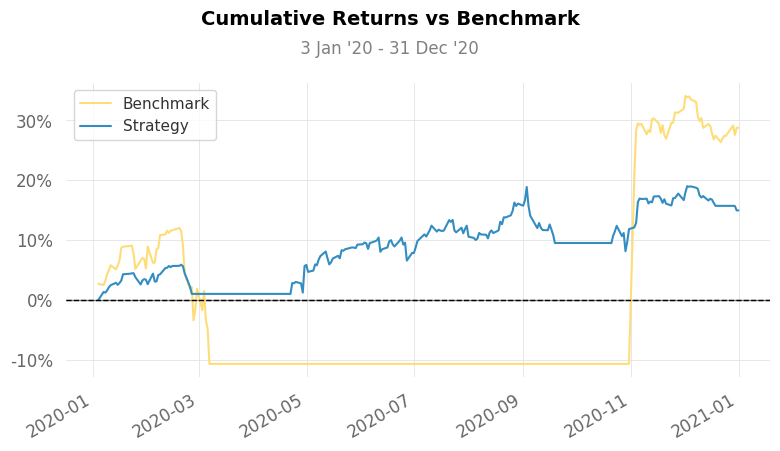

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


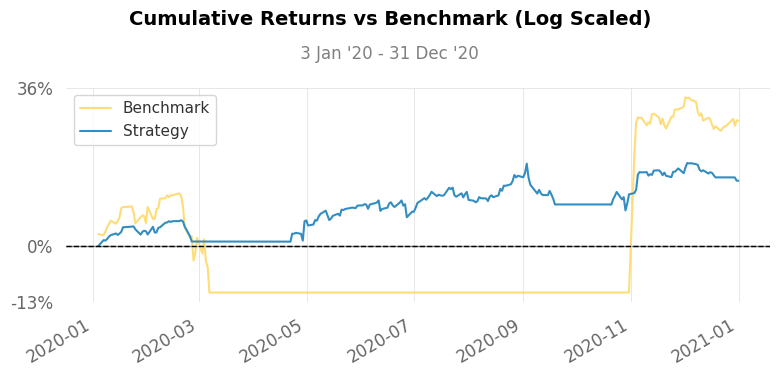

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


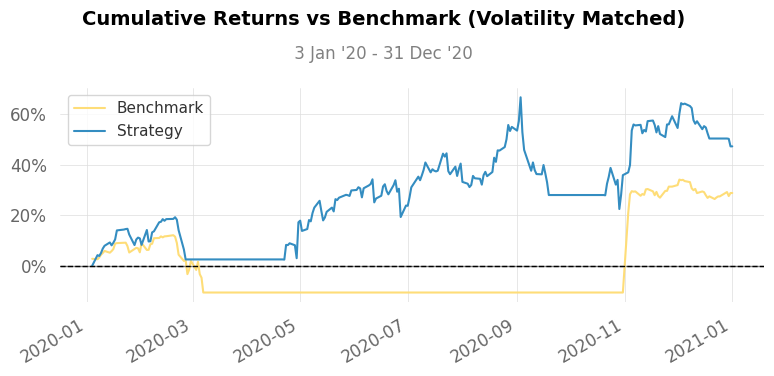

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


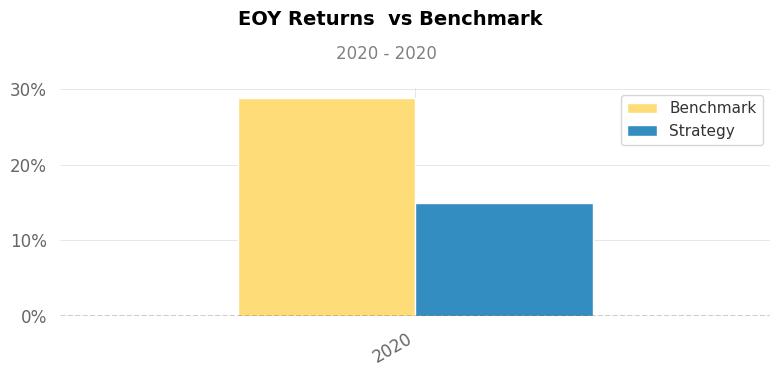

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


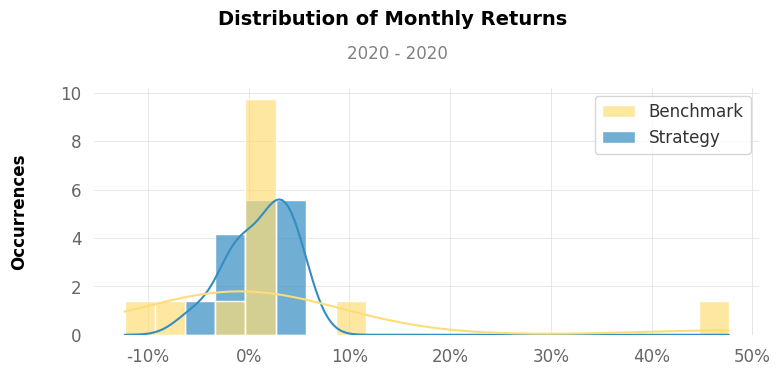

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


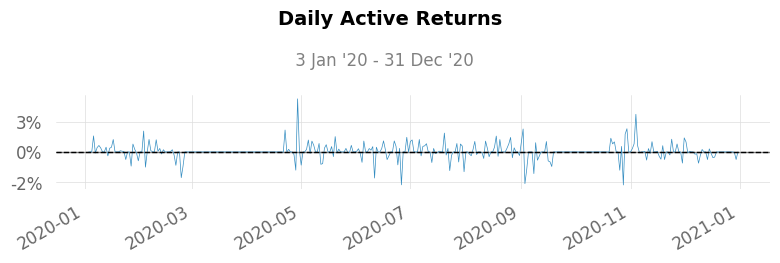

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


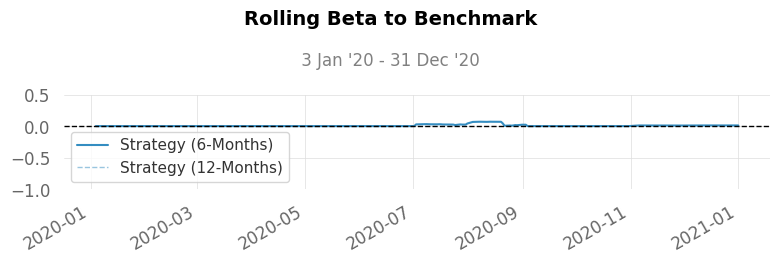

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


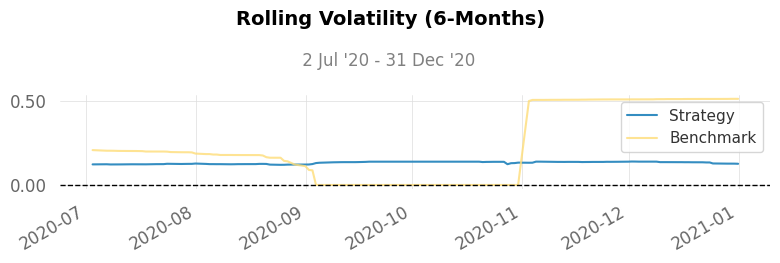

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


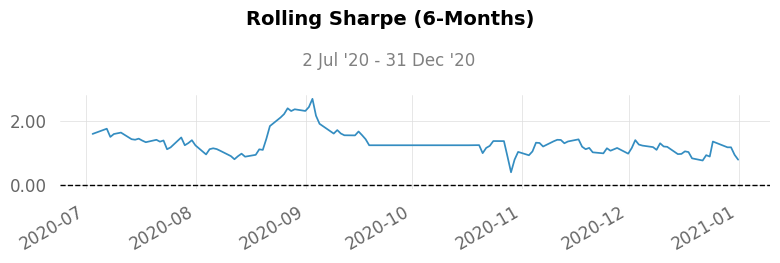

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


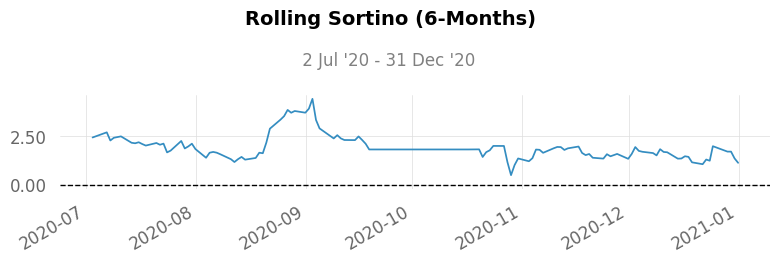

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


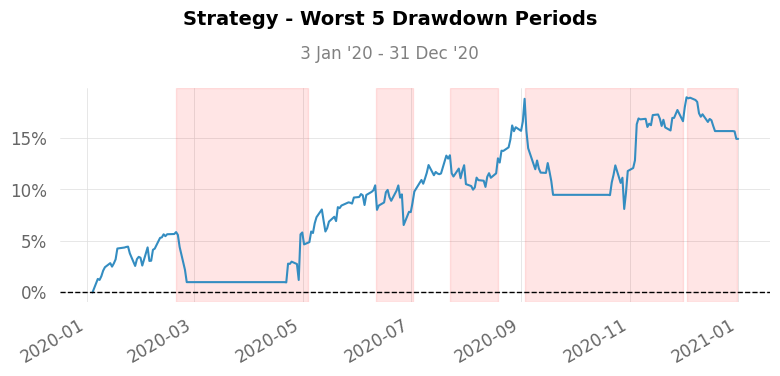

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


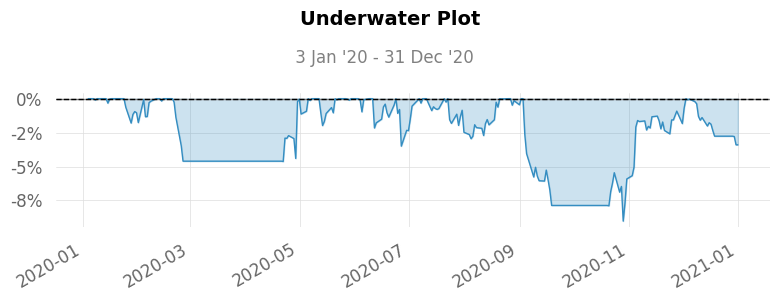

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


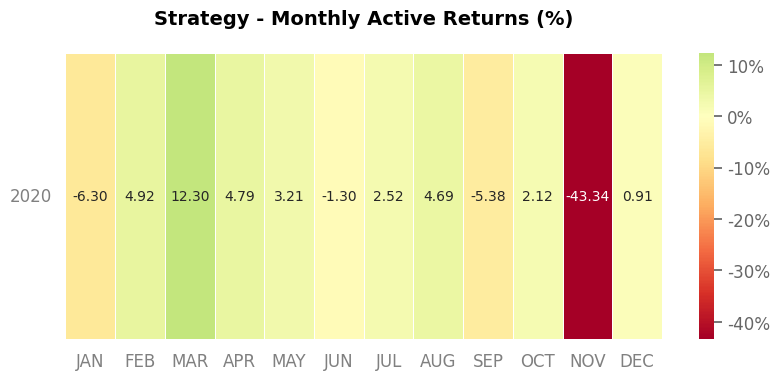

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


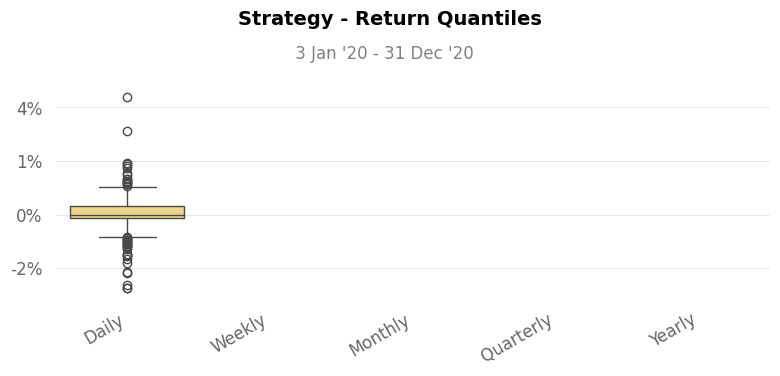

In [25]:
results.index = pd.to_datetime(results.index).tz_convert(None)

start = results.index[0]
end = results.index[-1]
benchmark = yf.download("GOOGL", start=start, end=end)["Close"].pct_change()
qs.reports.full(results.returns, benchmark=benchmark)